In [9]:
import numpy as np
import pandas as pd

df = pd.read_csv('Datasets/bank-additional-full.csv', delimiter=';')
np.int = np.int32

In [10]:
cols_to_drop = ['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
# at the same time, rename the columns so they are understandable. Please read the UCI page (https://archive.ics.uci.edu/ml/datasets/bank+marketing) for details
df = df.drop(columns=cols_to_drop).rename(columns={'job': 'job_type', 'default': 'default_status', 
                                                   'housing': 'housing_loan_status', 'loan': 'personal_loan_status', 
                                                   'contact': 'contact_type', 'month': 'contact_month', 
                                                   'day_of_week': 'contact_day_of_week', 'campaign': 'num_contacts', 
                                                   'pdays': 'days_last_contact', 'previous': 'previous_contacts', 
                                                   'poutcome': 'previous_outcome', 
                                                   'y': 'result'
                                                    })
# convert the target to numerical values
df['result'] = df['result'].replace({'yes': 1, 'no': 0})

C:\Users\aksha\AppData\Local\Temp\ipykernel_26840\2850889698.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['result'] = df['result'].replace({'yes': 1, 'no': 0})


In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='result')
y = df['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

In [12]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier

estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8)) # can customize objective function with the objective parameter
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [13]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=10, scoring='roc_auc', random_state=8) 

In [14]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [16]:
opt.score(X_test, y_test)

0.7801246521062314

In [18]:
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
opt.predict_proba(X_test)

array([[0.93451023, 0.06548979],
       [0.9548424 , 0.04515764],
       [0.9324591 , 0.06754087],
       ...,
       [0.7926921 , 0.20730786],
       [0.9559741 , 0.04402587],
       [0.84271353, 0.15728647]], dtype=float32)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

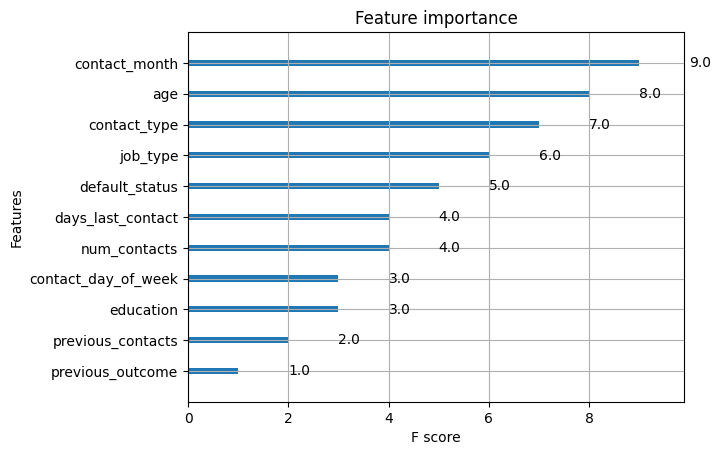

In [17]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)